# Insitu Validation

Select a group of stations from Fluxnet and or ISMN, retrieve their time series, longitude and latitude coordinates.   

Load the whole windsat dataset and select for the lat-lon of the station/s

Load a pre-trained model and predict surface temperature

Produce some statistics + plots, comparing ERA5 Surtep, Insitu Surtep and Predicted Surtep

In [51]:
# 
from timezonefinder import TimezoneFinder
from ismn.interface import ISMN_Interface
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import pickle

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))


from src.processing import windsat_datacube, model_preprocess, telsem_datacube, doy2month_mapping
from src.model import transform_batch, plot_history, xy_split

models_folder = "../../models/"
windsat_folder = "../../data/raw/Daily_Windsat/"
ISMN_path =  "../../data/raw/Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.zip"
fluxnet_folder = "../../data/raw/FLUXNET_CH4_has_2017_data/"
telsem_folder = "../../data/processed/WindsatEmiss/"



In [52]:
#Print available models:
print("Filenames in YYYYmmddTHHMMSS format: ")
for filename in os.listdir(models_folder):
    if filename.endswith(".keras"):
        print(filename)

Filenames in YYYYmmddTHHMMSS format: 
2024_05_28T103102.keras
2024_05_28T112040.keras
2024_05_28T112132.keras
2024_05_28T114946.keras
2024_05_28T140627.keras
2024_05_28T140851.keras
2024_05_28T150756.keras
2024_05_29T105032.keras
2024_05_29T111241.keras
2024_05_29T114725.keras
2024_06_03T083543.keras
2024_06_03T083839.keras
2024_06_03T092350.keras
2024_06_07T095429.keras
2024_06_07T095804.keras
checkpoint.keras
local_windsatv2_A_2024_06_13T111608.keras
local_windsatv2_D_2024_06_13T094319.keras
local_winsat_emissv2_1.keras
local_winsat_emissv2_1b.keras
local_winsat_emissv2_2.keras
local_winsat_emissv2_Catherine.keras
local_winsat_emissv2_D1.keras
local_winsat_emissv2_D2.keras
local_winsat_emissv2_larger1.keras
local_winsat_emiss_1.keras
local_winsat_emiss_10.keras
local_winsat_emiss_2.keras
local_winsat_emiss_3.keras
local_winsat_emiss_4.keras
local_winsat_emiss_5.keras
local_winsat_emiss_7.keras
local_winsat_emiss_8.keras
local_winsat_emiss_best.keras
WSMv2_2024_06_07T101014.keras
WSMv

In [53]:
# Load model
model_datestring = "WSMv2_A_2024_06_18T091325"
swath = 0 # A = 0, # D = 1

model_path = os.path.join(models_folder, model_datestring) + ".keras"
model = load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 60)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,995 (35.14 KB)

 Trainable params: 2,991 (11.68 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 5,984 (23.38 KB)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K²])'>,
        <Axes: title={'center': 'Epochs after loss < 15'}, xlabel='Epoch', ylabel='mse [K²]'>],
       dtype=object))

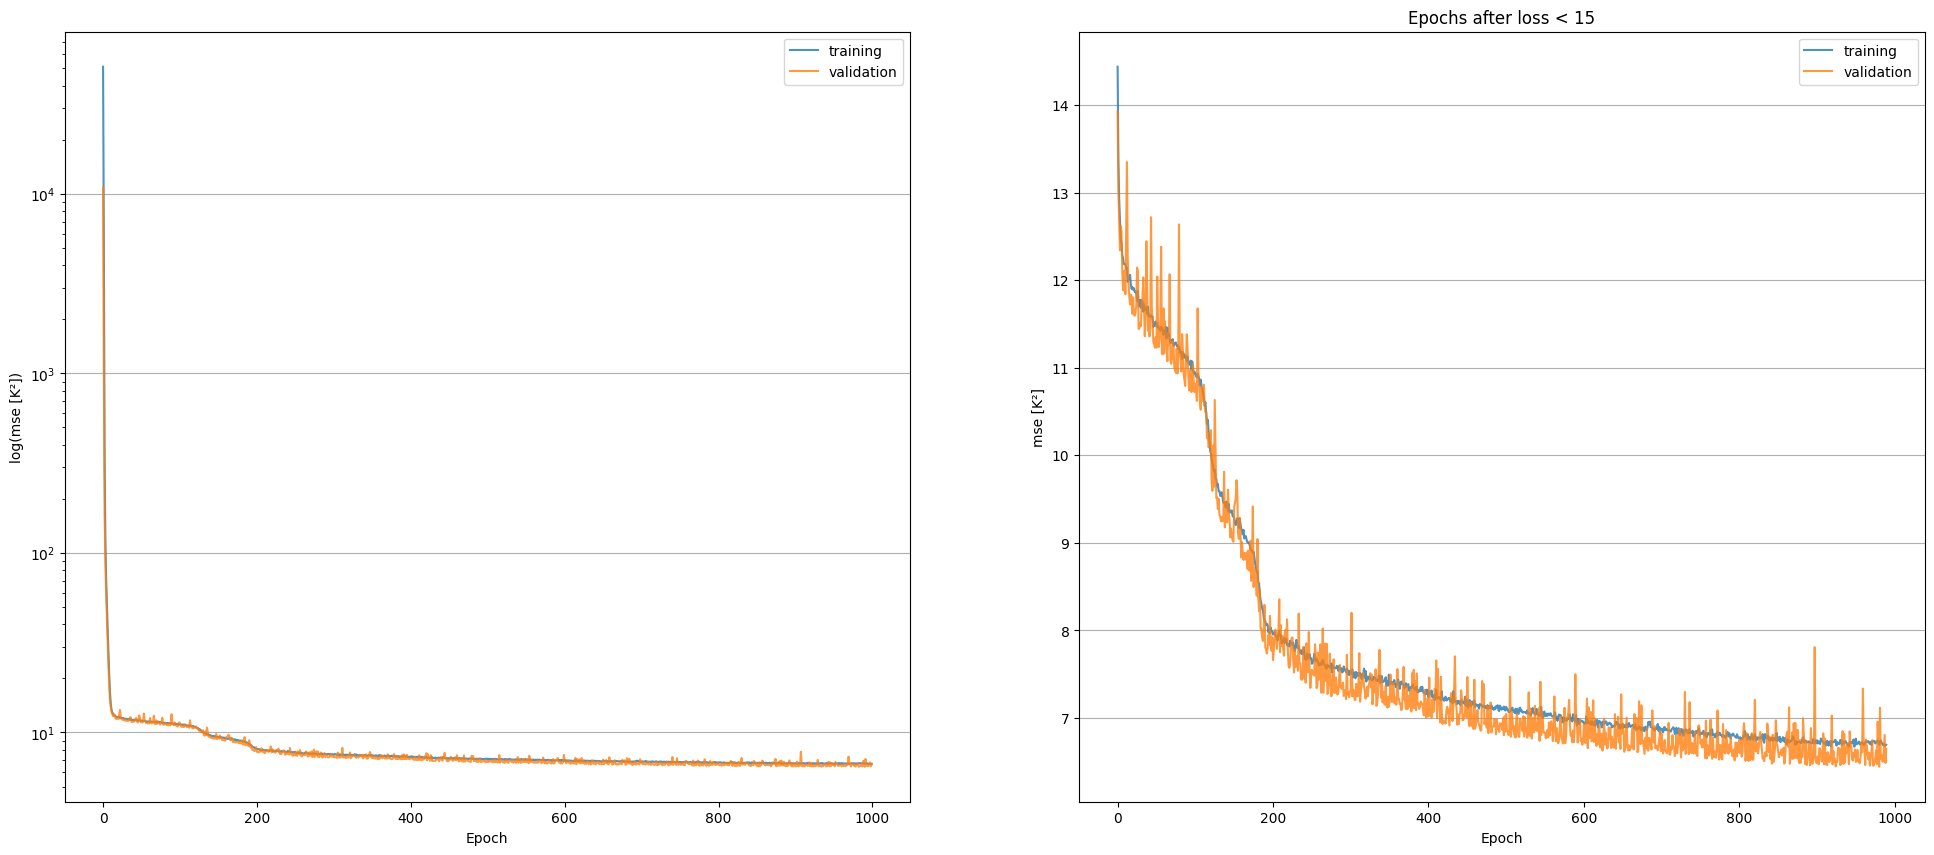

In [54]:
# Plot training history
history_path = os.path.join(models_folder, model_datestring + "_history")

# Training history
with open(history_path, "rb") as file:
    history = pickle.load(file)

plot_history(history, loss_threshold = 15)


In [55]:
# Load the windsat dataset:
ds = windsat_datacube(windsat_folder)

# Process the dataset an select ascending passes
swath_ds = model_preprocess(ds, swath_sector=swath)
swath_ds


<xarray.Dataset> Size: 896MB
Dimensions:         (day_number: 24, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 100MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [56]:

# Select dvars for the model prediction
d_vars = [
"surtep_ERA5",
"lat",
"lon",
"tbtoa_18Ghz_V",
"tbtoa_18Ghz_H",
"tbtoa_37Ghz_V",
"tbtoa_37Ghz_H",
"time_18Ghz",
"time_37Ghz",
]

swath_ds = swath_ds[d_vars]

# We need to select the subset of this dataset by latitude_grid, longitude_grid that
# matches a sensor lat-lon


### Load and select ISMN data

In [57]:
# Load ISMN data
ismn_data = ISMN_Interface(ISMN_path, parallel=True)
# Get the ids for the USCRN network and subset from the whole dataset.
ids = ismn_data.get_dataset_ids(
    variable=["surface_temperature"],
    filter_meta_dict={"network": "USCRN"},
)
uscrn_data = ismn_data.subset_from_ids(ids)
uscrn_data

Found existing ismn metadata in ..\..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.csv.
Found existing ismn metadata in ..\..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.csv.


ismn.base.IsmnRoot Zip at ..\..\data\raw\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.zip
with Networks[Stations]:
------------------------
  USCRN: ['Aberdeen_35_WNW', 'Arco_17_SW', 'Asheville_13_S', 'Asheville_8_SSW', 'Austin_33_NW', 'Avondale_2_N', 'Baker_5_W', 'Batesville_8_WNW', 'Bedford_5_WNW', 'Blackville_3_W', 'Bodega_6_WSW', 'Boulder_14_W', 'Bowling_Green_21_NNE', 'Brigham_City_28_WNW', 'Bronte_11_NNE', 'Brunswick_23_S', 'Buffalo_13_ESE', 'Cape_Charles_5_ENE', 'Champaign_9_SW', 'Charlottesville_2_SSE', 'Chatham_1_SE', 'Chillicothe_22_ENE', 'Coos_Bay_8_SW', 'Cortez_8_SE', 'Corvallis_10_SSW', 'Crossville_7_NW', 'Darrington_21_NNE', 'Denio_52_WSW', 'Des_Moines_17_E', 'Dillon_18_WSW', 'Dinosaur_2_E', 'Durham_11_W', 'Durham_2_N', 'Durham_2_SSW', 'Edinburg_17_NNE', 'Elgin_5_S', 'Elkins_21_ENE', 'Everglades_City_5_NE', 'Fairhope_3_NE', 'Fallbrook_5_NE', 'Gadsden_19_N', 'Gaylord_9_SSW', 'Goodridge_12_NNW', 'Goodwell_2_E', 'Goodwell_2_SE', 'Harrison_20_SSE', 'Holly_

In [58]:
# Extract the longitude and latitude of the sensors in the uscrn network
valid_sensors = []
for network, station, sensor in uscrn_data.collection.iter_sensors(depth=[0, 0]):
    if (
        np.min(sensor.data["surface_temperature"]) > -100
    ):  # Some data will have badly recovered LST
        valid_sensors.append((network, station, sensor))

len(valid_sensors)

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated an

113

In [104]:
# Retrieve the data into dataframes
tf = TimezoneFinder()

data_list = []
for network, station, sensor in valid_sensors[:] : 

    sensor_obj = uscrn_data[network.name][station.name][sensor.name]
    metadata = sensor_obj.metadata.to_pd()

    sensor_lat = metadata["latitude"]["val"]
    sensor_lon = metadata["longitude"]["val"]

    data_frame = sensor_obj.data

    # Convert local time into UTC knowing the latitude
    tz_name = tf.timezone_at(lng=sensor_lon, lat=sensor_lat)
    data_frame = data_frame.tz_localize(tz_name, nonexistent="shift_backward", ambiguous=True).tz_convert("UTC").tz_localize(None)

    data_list.append(
        (
            data_frame,
            (sensor_lon,sensor_lat)
        )
    )


c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated an

In [105]:
# Testing with a single sensor
sensor_data, sensor_coords = data_list[-4]

# Convert the sensor data from ºC to K 
sensor_data["surface_temperature"] = sensor_data["surface_temperature"].apply(lambda x: x + 273.15)

sensor_data

,surface_temperature,surface_temperature_flag,surface_temperature_orig_flag
date_time,,,
2017-01-01 07:00:00,269.65,G,0
2017-01-01 08:00:00,269.75,G,0
2017-01-01 09:00:00,269.25,G,0
2017-01-01 10:00:00,268.75,G,0
2017-01-01 11:00:00,268.35,G,0
...,...,...,...
2017-12-31 03:00:00,248.05,G,0
2017-12-31 04:00:00,248.35,G,0
2017-12-31 05:00:00,248.45,G,0


In [106]:
# Linear interpolation, then roud then to the closest grid point:
def map_lat(x, in_min=-90, in_max=90, out_min=0, out_max=719):
    return round( out_min + ( (x - in_min) / (in_max - in_min) ) * (out_max - out_min))

def map_lon(x, in_min=-180, in_max=180, out_min=0, out_max=1439):
    return round(out_min + ( (x - in_min) / (in_max - in_min) ) * (out_max - out_min))

latg, long = map_lat(sensor_coords[1]), map_lon(sensor_coords[0])
latg, long

(552, 299)

In [107]:
# Select the swath dataset on this grid pixel
sensor_ds = swath_ds.sel(latitude_grid = latg, longitude_grid = long)

In [108]:
# Cast it into a dataframe
sensor_df = sensor_ds.to_dataframe().dropna().reset_index("day_number")

# Map the day of the year (day_number) into the month:
day_mapping = doy2month_mapping()    
sensor_df["month"] = sensor_df["day_number"].apply(lambda x: day_mapping[x])

# drop the day_number column
sensor_df = sensor_df.drop(columns="day_number")
sensor_df


,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,latitude_grid,longitude_grid,month
0,280.305115,48.125,254.875,266.072510,248.880005,268.532501,258.762512,5.437182e+08,5.437183e+08,552,299,3
1,278.263306,48.125,254.875,267.972504,251.577484,269.892487,260.467499,5.438035e+08,5.438036e+08,552,299,3
2,285.129272,48.125,254.875,274.174988,266.070007,272.612488,267.164978,5.457897e+08,5.457897e+08,552,299,4
3,290.780365,48.125,254.875,280.207489,272.325012,278.857483,273.622498,5.471727e+08,5.471727e+08,552,299,5
4,294.236115,48.125,254.875,288.462494,281.362488,286.842499,282.424988,5.508891e+08,5.508891e+08,552,299,6
5,301.529175,48.125,254.875,295.854980,287.794983,293.784973,288.415009,5.537404e+08,5.537404e+08,552,299,7
6,293.572510,48.125,254.875,284.817505,276.877502,283.512482,278.704987,5.552939e+08,5.552940e+08,552,299,8
7,277.700989,48.125,254.875,272.410004,263.424988,270.725006,265.190002,5.609111e+08,5.609112e+08,552,299,10


In [109]:
# Load emissivities
telsem_ds = telsem_datacube(telsem_folder)

# Cast the mf dataset into a dataframe, add month as a column
telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")
telsem_df

month   Emis19V   Emis19H   Emis37V   Emis37H  \
latitude_grid longitude_grid                                                  
4             0                   1  0.838461  0.642331  0.850453  0.687476   
              1                   1  0.838612  0.642670  0.850646  0.687777   
              2                   1  0.838762  0.643009  0.850838  0.688078   
              3                   1  0.838912  0.643348  0.851031  0.688379   
              4                   1  0.839063  0.643688  0.851224  0.688679   
...                             ...       ...       ...       ...       ...   
693           609                12  0.929797  0.854530  0.850951  0.786876   
              610                12  0.929314  0.854520  0.845948  0.783754   
              611                12  0.928832  0.854509  0.840944  0.780632   
              612                12  0.929997  0.855679  0.836587  0.777149   
694           589                12  0.918187  0.844714  0.832307  0.772072   

                                 lat      lon  
latitude_grid longitude_grid                   
4             0              -88.875  180.125  
              1              -88.875  180.375  
              2              -88.875  180.625  
              3              -88.875  180.875  
              4              -88.875  181.125  
...                              ...      ...  
693           609             83.375  332.375  
              610             83.375  332.625  
              611             83.375  332.875  
              612             83.375  333.125  
694           589             83.625  327.375  

[4051772 rows x 7 columns]

In [110]:
# Combine windsat dataframe with emissivities
# Inner join the telsem df and the sensor df
combined_df = pd.merge(left=sensor_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")

# With so few samples, i need to do this for some reason:
combined_df = combined_df.drop(columns=["latitude_grid","longitude_grid"])

# TO_PREDICT dataframe. This will be passed onto the model
to_predict_df = combined_df.copy()

to_predict_df.drop(columns=["time_18Ghz","time_37Ghz"], inplace=True)

# Transform lat and lon to be periodic functions
to_predict_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
to_predict_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

to_predict_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,280.305115,0.744603,-0.965359,266.072510,248.880005,268.532501,258.762512,0.964341,0.909513,0.939694,0.897091
1,278.263306,0.744603,-0.965359,267.972504,251.577484,269.892487,260.467499,0.964341,0.909513,0.939694,0.897091
2,285.129272,0.744603,-0.965359,274.174988,266.070007,272.612488,267.164978,0.972356,0.935616,0.959026,0.931587
3,290.780365,0.744603,-0.965359,280.207489,272.325012,278.857483,273.622498,0.971943,0.945170,0.957935,0.938289
4,294.236115,0.744603,-0.965359,288.462494,281.362488,286.842499,282.424988,0.966610,0.941507,0.952853,0.935009
5,301.529175,0.744603,-0.965359,295.854980,287.794983,293.784973,288.415009,0.967924,0.944128,0.954318,0.936572
6,293.572510,0.744603,-0.965359,284.817505,276.877502,283.512482,278.704987,0.971766,0.943971,0.957557,0.937710
7,277.700989,0.744603,-0.965359,272.410004,263.424988,270.725006,265.190002,0.970240,0.937700,0.956910,0.932469


In [111]:
X , _ = xy_split(to_predict_df, y_column = "surtep_ERA5")
combined_df["surtep_MODEL"] = model.predict(X)
combined_df[["surtep_MODEL","surtep_ERA5","time_18Ghz"]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


,surtep_MODEL,surtep_ERA5,time_18Ghz
0,280.271942,280.305115,5.437182e+08
1,280.823334,278.263306,5.438035e+08
2,280.577911,285.129272,5.457897e+08
3,288.121216,290.780365,5.471727e+08
4,296.591095,294.236115,5.508891e+08
5,303.637787,301.529175,5.537404e+08
6,292.217072,293.572510,5.552939e+08
7,280.035187,277.700989,5.609111e+08


---

To correctly map the sensor data to the predictions and ERA5 LST we need to keep the time dvar in swath_ds

In [112]:
# Transform the time from senconds since 2000-01-01T00:00:00 into a datetime object.
from datetime import datetime, timedelta
def get_datetime_from_secods(seconds):
    reference_dt = datetime(2000,1,1,0,0,0)
    return reference_dt + timedelta(seconds=seconds)

combined_df["time_18Ghz"] = combined_df["time_18Ghz"].apply(lambda x : get_datetime_from_secods(x))
combined_df["time_37Ghz"] = combined_df["time_37Ghz"].apply(lambda x : get_datetime_from_secods(x))
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,Emis19V,Emis19H,Emis37V,Emis37H,surtep_MODEL
0,280.305115,48.125,254.875,266.072510,248.880005,268.532501,258.762512,2017-03-25 00:50:49.475906,2017-03-25 00:51:01.075907,0.964341,0.909513,0.939694,0.897091,280.271942
1,278.263306,48.125,254.875,267.972504,251.577484,269.892487,260.467499,2017-03-26 00:32:25.340531,2017-03-26 00:32:35.890531,0.964341,0.909513,0.939694,0.897091,280.823334
2,285.129272,48.125,254.875,274.174988,266.070007,272.612488,267.164978,2017-04-18 00:15:18.741792,2017-04-18 00:15:29.641792,0.972356,0.935616,0.959026,0.931587,280.577911
3,290.780365,48.125,254.875,280.207489,272.325012,278.857483,273.622498,2017-05-04 00:24:58.444501,2017-05-04 00:25:08.594501,0.971943,0.945170,0.957935,0.938289,288.121216
4,294.236115,48.125,254.875,288.462494,281.362488,286.842499,282.424988,2017-06-16 00:44:46.965144,2017-06-16 00:44:57.765144,0.966610,0.941507,0.952853,0.935009,296.591095
5,301.529175,48.125,254.875,295.854980,287.794983,293.784973,288.415009,2017-07-19 00:45:54.732239,2017-07-19 00:46:05.832239,0.967924,0.944128,0.954318,0.936572,303.637787
6,293.572510,48.125,254.875,284.817505,276.877502,283.512482,278.704987,2017-08-06 00:19:07.414290,2017-08-06 00:19:18.114290,0.971766,0.943971,0.957557,0.937710,292.217072
7,277.700989,48.125,254.875,272.410004,263.424988,270.725006,265.190002,2017-10-10 00:39:02.782760,2017-10-10 00:39:13.232760,0.970240,0.937700,0.956910,0.932469,280.035187


C:\Users\andre\AppData\Local\Temp\ipykernel_17816\2528166740.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


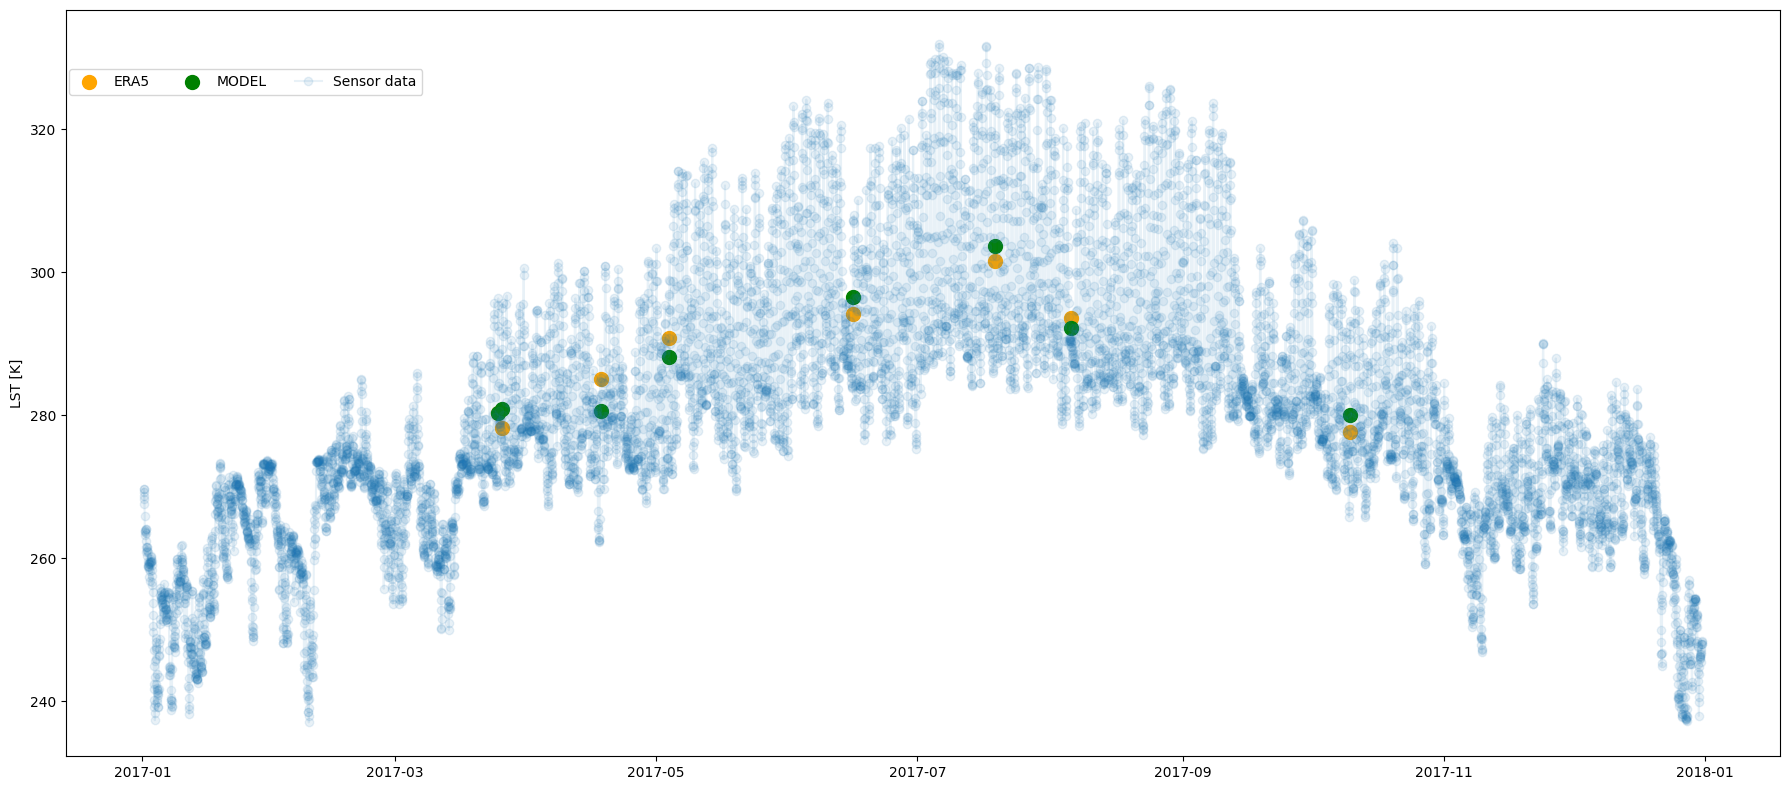

In [70]:
# Now we can plot both the sensor data and the predicted surtep, alongiside the ERA5 prediction:
fig, ax = plt.subplots(1,1,figsize =(18,8))

ax.scatter(x = combined_df["time_37Ghz"], y = combined_df["surtep_ERA5"], marker="o", label = "ERA5", s = 100, color = "Orange")
ax.scatter(x = combined_df["time_37Ghz"], y = combined_df["surtep_MODEL"], marker="o", label = "MODEL", s = 100, color = "Green")

ax.plot(sensor_data["surface_temperature"], marker = "o", label = "Sensor data", alpha = 0.1)

ax.set_ylabel("LST [K]")

fig.legend(loc = "upper left", ncol=3, borderaxespad=5)
fig.tight_layout()
fig.show()



In [113]:
# Select the closest measurements for each prediction time:

# We need to index the prediction dataframe using the time columns, since both frequencies differ by a few seconds lets just use the 18Ghz values

prediction_df = combined_df.sort_values("time_18Ghz")
prediction_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,Emis19V,Emis19H,Emis37V,Emis37H,surtep_MODEL
0,280.305115,48.125,254.875,266.072510,248.880005,268.532501,258.762512,2017-03-25 00:50:49.475906,2017-03-25 00:51:01.075907,0.964341,0.909513,0.939694,0.897091,280.271942
1,278.263306,48.125,254.875,267.972504,251.577484,269.892487,260.467499,2017-03-26 00:32:25.340531,2017-03-26 00:32:35.890531,0.964341,0.909513,0.939694,0.897091,280.823334
2,285.129272,48.125,254.875,274.174988,266.070007,272.612488,267.164978,2017-04-18 00:15:18.741792,2017-04-18 00:15:29.641792,0.972356,0.935616,0.959026,0.931587,280.577911
3,290.780365,48.125,254.875,280.207489,272.325012,278.857483,273.622498,2017-05-04 00:24:58.444501,2017-05-04 00:25:08.594501,0.971943,0.945170,0.957935,0.938289,288.121216
4,294.236115,48.125,254.875,288.462494,281.362488,286.842499,282.424988,2017-06-16 00:44:46.965144,2017-06-16 00:44:57.765144,0.966610,0.941507,0.952853,0.935009,296.591095
5,301.529175,48.125,254.875,295.854980,287.794983,293.784973,288.415009,2017-07-19 00:45:54.732239,2017-07-19 00:46:05.832239,0.967924,0.944128,0.954318,0.936572,303.637787
6,293.572510,48.125,254.875,284.817505,276.877502,283.512482,278.704987,2017-08-06 00:19:07.414290,2017-08-06 00:19:18.114290,0.971766,0.943971,0.957557,0.937710,292.217072
7,277.700989,48.125,254.875,272.410004,263.424988,270.725006,265.190002,2017-10-10 00:39:02.782760,2017-10-10 00:39:13.232760,0.970240,0.937700,0.956910,0.932469,280.035187


In [114]:
# Match the closest measurement to each prediction
compare_df = pd.merge_asof(prediction_df, sensor_data, left_on="time_18Ghz",right_index=True)
compare_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,Emis19V,Emis19H,Emis37V,Emis37H,surtep_MODEL,surface_temperature,surface_temperature_flag,surface_temperature_orig_flag
0,280.305115,48.125,254.875,266.072510,248.880005,268.532501,258.762512,2017-03-25 00:50:49.475906,2017-03-25 00:51:01.075907,0.964341,0.909513,0.939694,0.897091,280.271942,288.55,G,0
1,278.263306,48.125,254.875,267.972504,251.577484,269.892487,260.467499,2017-03-26 00:32:25.340531,2017-03-26 00:32:35.890531,0.964341,0.909513,0.939694,0.897091,280.823334,287.45,G,0
2,285.129272,48.125,254.875,274.174988,266.070007,272.612488,267.164978,2017-04-18 00:15:18.741792,2017-04-18 00:15:29.641792,0.972356,0.935616,0.959026,0.931587,280.577911,289.45,G,0
3,290.780365,48.125,254.875,280.207489,272.325012,278.857483,273.622498,2017-05-04 00:24:58.444501,2017-05-04 00:25:08.594501,0.971943,0.945170,0.957935,0.938289,288.121216,296.65,G,0
4,294.236115,48.125,254.875,288.462494,281.362488,286.842499,282.424988,2017-06-16 00:44:46.965144,2017-06-16 00:44:57.765144,0.966610,0.941507,0.952853,0.935009,296.591095,304.55,G,0
5,301.529175,48.125,254.875,295.854980,287.794983,293.784973,288.415009,2017-07-19 00:45:54.732239,2017-07-19 00:46:05.832239,0.967924,0.944128,0.954318,0.936572,303.637787,317.65,G,0
6,293.572510,48.125,254.875,284.817505,276.877502,283.512482,278.704987,2017-08-06 00:19:07.414290,2017-08-06 00:19:18.114290,0.971766,0.943971,0.957557,0.937710,292.217072,290.05,G,0
7,277.700989,48.125,254.875,272.410004,263.424988,270.725006,265.190002,2017-10-10 00:39:02.782760,2017-10-10 00:39:13.232760,0.970240,0.937700,0.956910,0.932469,280.035187,288.45,G,0


C:\Users\andre\AppData\Local\Temp\ipykernel_17816\3369557656.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


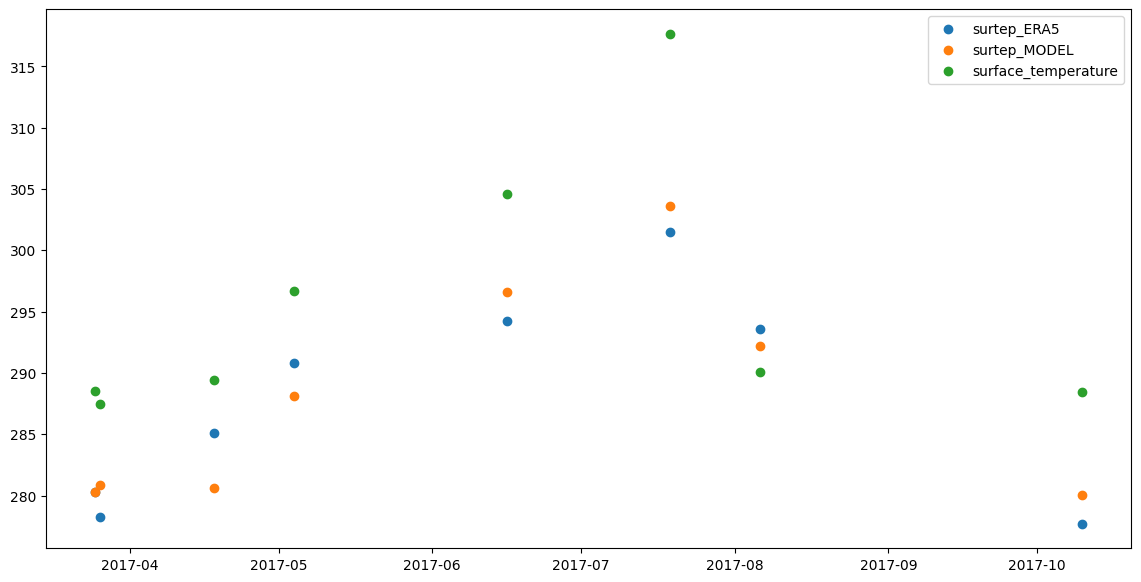

In [115]:
# compare the tree LST
fig, ax = plt.subplots(1,1,figsize = (14,7))

for column in ["surtep_ERA5","surtep_MODEL","surface_temperature"]:
    ax.scatter(x = combined_df["time_18Ghz"], y = compare_df[column], label = f"{column}")

ax.legend()
fig.show()


# TODO:  
Aggregate all predictions for all the stations and create some histograms of the error values both from ERA5 and the MODEL

The metadata on the station's time of measurement is missing, googling th ismn then uscrn networks seems to suggest that the measured date is in local time for each sensor, which needs to be corrected if true.

Maybe do this in a Bokeh graph to switch between sensors easily ? 

In [119]:
# Lets calculate the predicted LST with the model and retrieve the ERA5 LST for every data point in the sensor list
all_predictions_df = pd.DataFrame()

for i, data in enumerate(data_list):
    sensor_data, sensor_coords = data

    print(f"Sensor{i+1}/{len(data_list)}: ")
    # Selec the closest grid point
    latg, long = map_lat(sensor_coords[1]), map_lon(sensor_coords[0])
    sensor_ds = swath_ds.sel(latitude_grid = latg, longitude_grid = long)

    # Cast it into a dataframe
    sensor_df = sensor_ds.to_dataframe().dropna().reset_index("day_number")

    if len(sensor_df) == 0:
        print("\t No data, skip sensor")
        continue

    # Map the day of the year (day_number) into the month:
    day_mapping = doy2month_mapping()    
    sensor_df["month"] = sensor_df["day_number"].apply(lambda x: day_mapping[x])

    # drop the day_number column
    sensor_df = sensor_df.drop(columns="day_number")

    # Inner join the telsem df and the sensor df
    combined_df = pd.merge(left=sensor_df, right=telsem_df, how="inner")

    # Drop the month column
    combined_df = combined_df.drop(columns="month")

    # With so few samples, i need to do this for some reason:
    combined_df = combined_df.drop(columns=["latitude_grid","longitude_grid"])


    # TO_PREDICT dataframe. This will be passed onto the model
    to_predict_df = combined_df.copy()

    to_predict_df.drop(columns=["time_18Ghz","time_37Ghz"], inplace=True)

    # Transform lat and lon to be periodic functions
    to_predict_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
    to_predict_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

    X , _ = xy_split(to_predict_df, y_column = "surtep_ERA5")
    combined_df["surtep_MODEL"] = model.predict(X, verbose = 0)

    # Transform senconds into datetime
    combined_df["time_18Ghz"] = combined_df["time_18Ghz"].apply(lambda x : get_datetime_from_secods(x))
    combined_df["time_37Ghz"] = combined_df["time_37Ghz"].apply(lambda x : get_datetime_from_secods(x))

    # Join the sensor measurement with the predictions from ERA5 and the model
    combined_df.sort_values("time_18Ghz", inplace=True)
    sensor_data.sort_index(inplace=True)
    compare_df = pd.merge_asof(combined_df, sensor_data, left_on="time_18Ghz",right_index=True)

    # Concatenate with the full dataset
    all_predictions_df = pd.concat([all_predictions_df,compare_df])
print("DONE")

Sensor1/113: 
Sensor2/113: 
Sensor3/113: 
Sensor4/113: 
Sensor5/113: 
Sensor6/113: 
Sensor7/113: 
Sensor8/113: 
Sensor9/113: 
Sensor10/113: 
Sensor11/113: 
Sensor12/113: 
Sensor13/113: 
Sensor14/113: 
Sensor15/113: 
Sensor16/113: 
	 No data, skip sensor
Sensor17/113: 
Sensor18/113: 
	 No data, skip sensor
Sensor19/113: 
Sensor20/113: 
Sensor21/113: 
Sensor22/113: 
Sensor23/113: 
Sensor24/113: 
Sensor25/113: 
Sensor26/113: 
Sensor27/113: 
Sensor28/113: 
Sensor29/113: 
Sensor30/113: 
Sensor31/113: 
Sensor32/113: 
Sensor33/113: 
Sensor34/113: 
Sensor35/113: 
Sensor36/113: 
Sensor37/113: 
Sensor38/113: 
Sensor39/113: 
Sensor40/113: 
Sensor41/113: 
Sensor42/113: 
Sensor43/113: 
Sensor44/113: 
Sensor45/113: 
Sensor46/113: 
Sensor47/113: 
Sensor48/113: 
Sensor49/113: 
Sensor50/113: 
Sensor51/113: 
Sensor52/113: 
Sensor53/113: 
	 No data, skip sensor
Sensor54/113: 
	 No data, skip sensor
Sensor55/113: 
Sensor56/113: 
Sensor57/113: 
Sensor58/113: 
Sensor59/113: 
Sensor60/113: 
Sensor61/113: 
Se

In [120]:
all_predictions_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,Emis19V,Emis19H,Emis37V,Emis37H,surtep_MODEL,surface_temperature,surface_temperature_flag,surface_temperature_orig_flag
0,284.694031,45.625,260.875,268.729980,254.187500,270.742493,261.862488,2017-04-18 23:56:08.505257,2017-04-18 23:56:19.205257,0.938534,0.883709,0.932904,0.884970,284.536835,9.0,G,0.0
1,288.193604,45.625,260.875,276.789978,266.724976,276.065002,268.642487,2017-05-04 00:24:06.394501,2017-05-04 00:24:17.094501,0.932612,0.879204,0.925537,0.877986,289.610016,28.3,G,0.0
2,292.486328,45.625,260.875,281.087494,270.647491,280.054993,272.297485,2017-05-05 00:05:48.265381,2017-05-05 00:05:58.565381,0.932612,0.879204,0.925537,0.877986,294.224457,34.9,G,0.0
3,293.188202,45.625,260.875,277.404999,271.917480,276.570007,272.632507,2017-08-06 00:18:07.164290,2017-08-06 00:18:17.814290,0.935321,0.901748,0.921859,0.888584,290.018768,24.1,G,0.0
0,291.733429,43.375,246.625,282.479980,275.234985,281.697479,276.612488,2017-06-15 01:02:03.123231,2017-06-15 01:02:13.573231,0.959430,0.936741,0.946847,0.929828,293.545074,27.3,G,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,294.022827,37.625,240.375,284.459991,281.929993,283.785004,281.857483,2017-08-06 01:57:23.946761,2017-08-06 01:57:35.396761,0.934490,0.918553,0.920644,0.907064,297.106476,29.8,G,0.0
0,304.857758,32.875,245.875,288.940002,271.200012,285.144989,273.267487,2017-04-19 01:33:42.032001,2017-04-19 01:33:52.832001,0.932698,0.882222,0.911446,0.874793,304.449585,42.2,G,0.0
1,313.843323,32.875,245.875,297.702515,280.522491,294.205017,283.119995,2017-08-07 01:37:36.095894,2017-08-07 01:37:47.395894,0.932107,0.883236,0.909101,0.874134,312.200165,49.4,G,0.0
2,300.377441,32.875,245.875,288.869995,273.147491,287.477478,277.309998,2017-09-10 01:20:15.690029,2017-09-10 01:20:25.740029,0.936462,0.885744,0.913715,0.876686,304.146362,25.0,G,0.0


# TODO: 

Passing time is suposed to be close to 6 AM / 6PM, the times we selected are lose to 12 AM, 12 PM, which means that the time dimention in insitu measurements must be local time, not UTC (Windsat uses that one).

C:\Users\andre\AppData\Local\Temp\ipykernel_17816\55402859.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


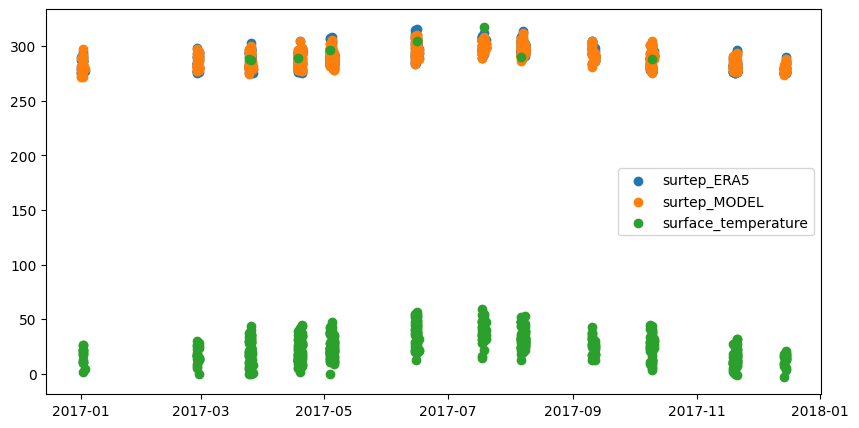

In [121]:
# Plots:
fig, ax = plt.subplots(1,1,figsize = (10,5))

for column in ["surtep_ERA5","surtep_MODEL","surface_temperature"]:
    ax.scatter(x = all_predictions_df["time_18Ghz"], y = all_predictions_df[column], label = f"{column}")
ax.legend()
fig.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_17816\2865022878.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


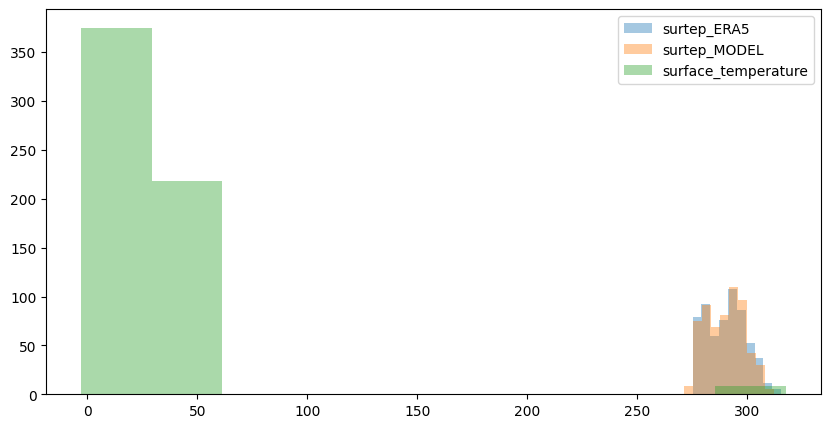

In [122]:
# Plots:
fig, ax = plt.subplots(1,1,figsize = (10,5))

for column in ["surtep_ERA5","surtep_MODEL","surface_temperature"]:
    ax.hist(all_predictions_df[column], label = f"{column}", alpha = 0.4)

ax.legend()
fig.show()


#### There are a lot of missing values in the measurements
lets keep only measurements with LST in [200,400] kelvin

NOTE! 

Some of the measurements are in ºC !! 

In [123]:
# Some of the sensors have the temperature recorde in ºC: Quick fix
all_predictions_df["surface_temperature"] = all_predictions_df["surface_temperature"].apply(
    lambda x: x + 273.15 if x < 100 else x
)

In [124]:
df = all_predictions_df[
    all_predictions_df["surface_temperature"] > 200 
]
df = df[df["surface_temperature"] < 400 ]
df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,Emis19V,Emis19H,Emis37V,Emis37H,surtep_MODEL,surface_temperature,surface_temperature_flag,surface_temperature_orig_flag
0,284.694031,45.625,260.875,268.729980,254.187500,270.742493,261.862488,2017-04-18 23:56:08.505257,2017-04-18 23:56:19.205257,0.938534,0.883709,0.932904,0.884970,284.536835,282.15,G,0.0
1,288.193604,45.625,260.875,276.789978,266.724976,276.065002,268.642487,2017-05-04 00:24:06.394501,2017-05-04 00:24:17.094501,0.932612,0.879204,0.925537,0.877986,289.610016,301.45,G,0.0
2,292.486328,45.625,260.875,281.087494,270.647491,280.054993,272.297485,2017-05-05 00:05:48.265381,2017-05-05 00:05:58.565381,0.932612,0.879204,0.925537,0.877986,294.224457,308.05,G,0.0
3,293.188202,45.625,260.875,277.404999,271.917480,276.570007,272.632507,2017-08-06 00:18:07.164290,2017-08-06 00:18:17.814290,0.935321,0.901748,0.921859,0.888584,290.018768,297.25,G,0.0
0,291.733429,43.375,246.625,282.479980,275.234985,281.697479,276.612488,2017-06-15 01:02:03.123231,2017-06-15 01:02:13.573231,0.959430,0.936741,0.946847,0.929828,293.545074,300.45,G,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,294.022827,37.625,240.375,284.459991,281.929993,283.785004,281.857483,2017-08-06 01:57:23.946761,2017-08-06 01:57:35.396761,0.934490,0.918553,0.920644,0.907064,297.106476,302.95,G,0.0
0,304.857758,32.875,245.875,288.940002,271.200012,285.144989,273.267487,2017-04-19 01:33:42.032001,2017-04-19 01:33:52.832001,0.932698,0.882222,0.911446,0.874793,304.449585,315.35,G,0.0
1,313.843323,32.875,245.875,297.702515,280.522491,294.205017,283.119995,2017-08-07 01:37:36.095894,2017-08-07 01:37:47.395894,0.932107,0.883236,0.909101,0.874134,312.200165,322.55,G,0.0
2,300.377441,32.875,245.875,288.869995,273.147491,287.477478,277.309998,2017-09-10 01:20:15.690029,2017-09-10 01:20:25.740029,0.936462,0.885744,0.913715,0.876686,304.146362,298.15,G,0.0


C:\Users\andre\AppData\Local\Temp\ipykernel_17816\491462079.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


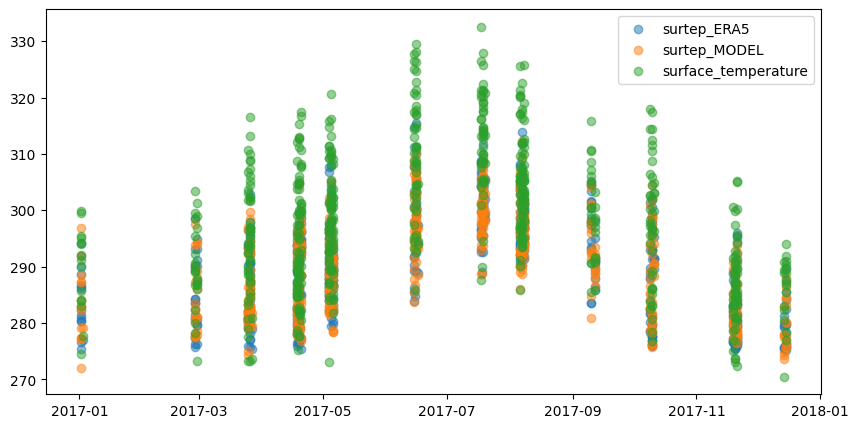

In [125]:
# Plots:
fig, ax = plt.subplots(1,1,figsize = (10,5))

for column in ["surtep_ERA5","surtep_MODEL","surface_temperature"]:
    ax.scatter(x = df["time_18Ghz"], y = df[column], label = f"{column}", alpha = 0.5)

ax.legend()
fig.show()



C:\Users\andre\AppData\Local\Temp\ipykernel_17816\162555582.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


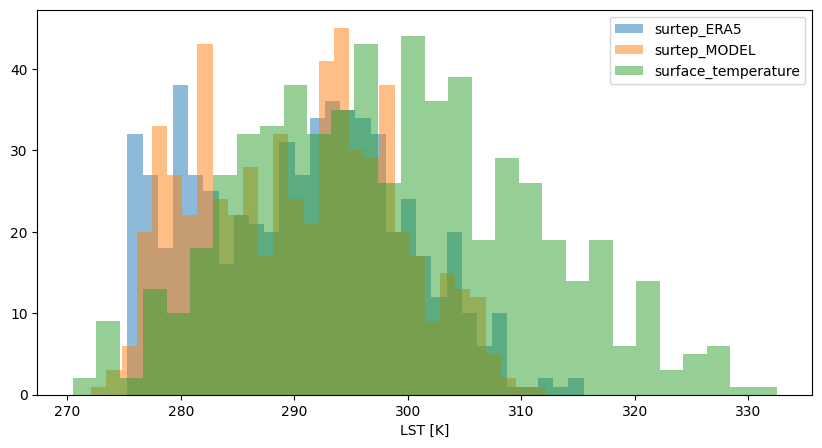

In [126]:
# Hist:
fig, ax = plt.subplots(1,1,figsize = (10,5))

for column in ["surtep_ERA5","surtep_MODEL","surface_temperature"]:
    ax.hist(df[column], label = f"{column}", alpha = 0.5, bins = 30)
ax.set_xlabel("LST [K]")
ax.legend()
fig.show()

Too few samples in local dataset to show any distribution

C:\Users\andre\AppData\Local\Temp\ipykernel_17816\3725724381.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


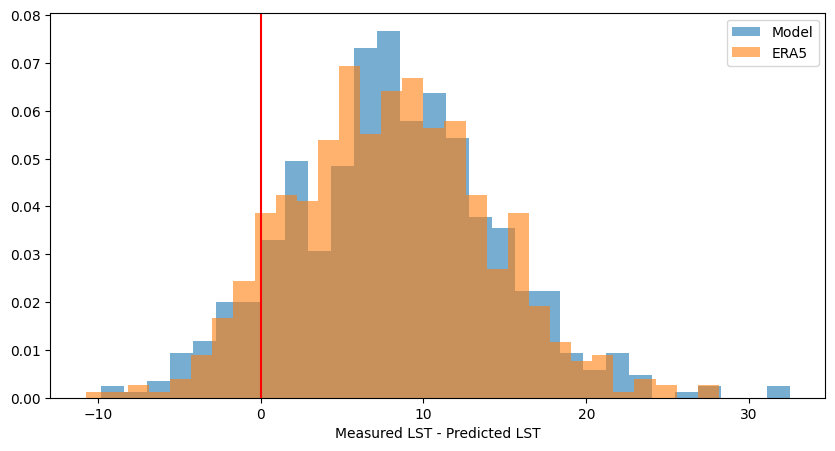

In [127]:
# Compute the model error vs the ERA5 error for all valid samples
df["MODEL_err"] = df["surface_temperature"] - df["surtep_MODEL"]
df["ERA5_err"] = df["surface_temperature"] - df["surtep_ERA5"]

fig, ax = plt.subplots(1,1,figsize = (10,5))
common_kws =  {"alpha": 0.6, "bins": 30, "density": True}

ax.hist(df["MODEL_err"], label = "Model", **common_kws)
ax.hist(df["ERA5_err"], label= "ERA5", **common_kws)

ax.legend()
ax.axvline(x = 0, color = "Red")
ax.set_xlabel("Measured LST - Predicted LST")
fig.show()
